# Classification of the Data

In [2]:
import pandas as pd

df_cleaned_data = pd.read_csv("./data/data_1.csv", parse_dates=["date_time"])
#df_cleaned_data["date_time"] = pd.to_datetime(df_cleaned_data["date_time"], format='%Y-%m-%d %H:%M:%S')
print(df_cleaned_data.dtypes)


Unnamed: 0                       int64
obs_number                       int64
time                            object
ID                               int64
date_time               datetime64[ns]
mood                           float64
circumplex.arousal             float64
circumplex.valence             float64
activity                       float64
screen                         float64
call                           float64
sms                            float64
appCat.builtin                 float64
appCat.communication           float64
appCat.entertainment           float64
appCat.finance                 float64
appCat.game                    float64
appCat.office                  float64
appCat.other                   float64
appCat.social                  float64
appCat.travel                  float64
appCat.unknown                 float64
appCat.utilities               float64
appCat.weather                 float64
date                            object
hour                     

2014-03-21 21:00:00
2014-03-22 12:00:00
2014-03-21 22:00:00 2014-03-22 07:00:00
9


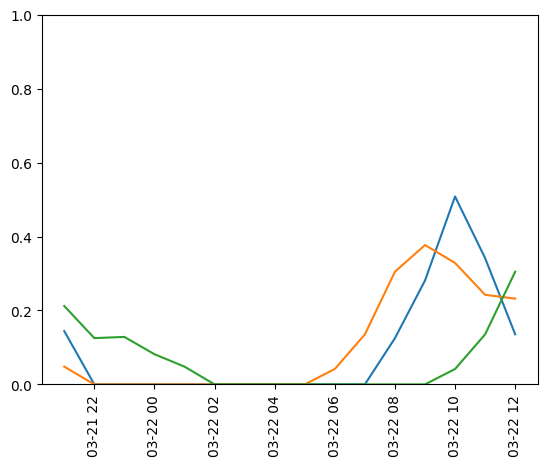

2014-03-22 21:00:00
2014-03-23 12:00:00
nan


/tmp/ipykernel_6623/802887068.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_potential_sleep_interval.fillna(0, inplace=True)


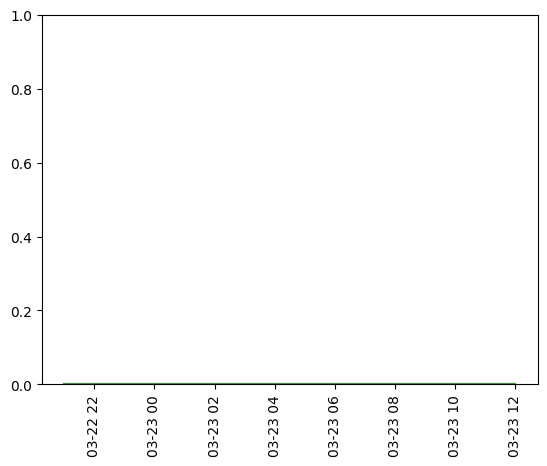

2014-03-23 21:00:00
2014-03-24 12:00:00
2014-03-23 22:00:00 2014-03-24 07:00:00
9


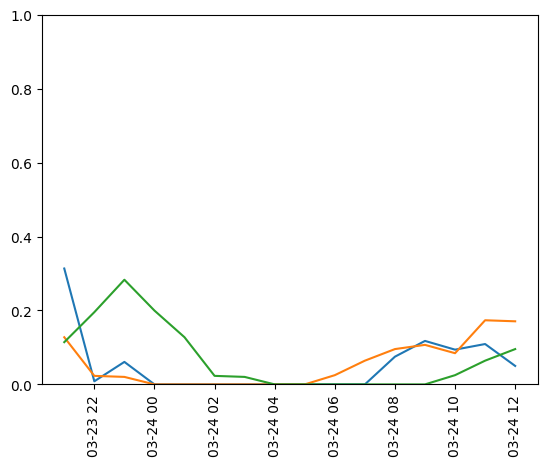

2014-03-24 21:00:00
2014-03-25 12:00:00
2014-03-24 22:00:00 2014-03-25 08:00:00
10


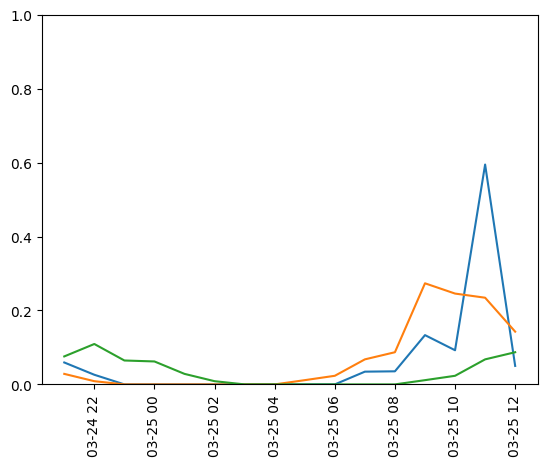

2014-03-25 21:00:00
2014-03-26 12:00:00
nan


/tmp/ipykernel_6623/802887068.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_potential_sleep_interval.fillna(0, inplace=True)


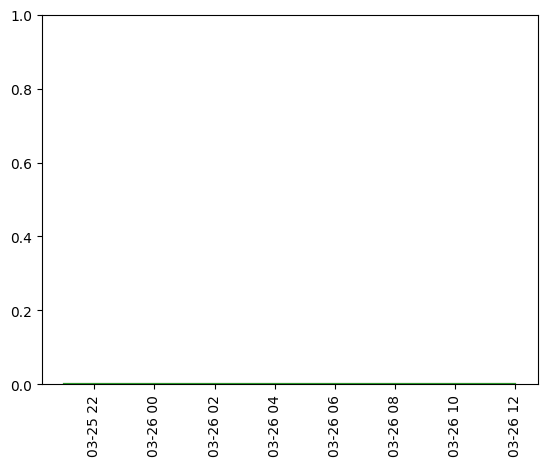

2014-03-26 21:00:00
2014-03-27 12:00:00
2014-03-26 22:00:00 2014-03-27 08:00:00
10


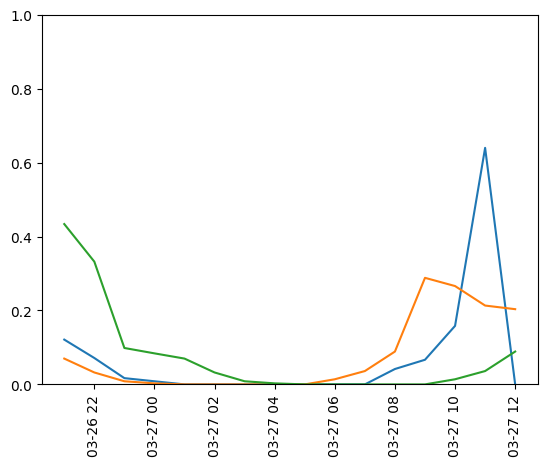

2014-03-27 21:00:00
2014-03-28 12:00:00
nan


/tmp/ipykernel_6623/802887068.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_potential_sleep_interval.fillna(0, inplace=True)


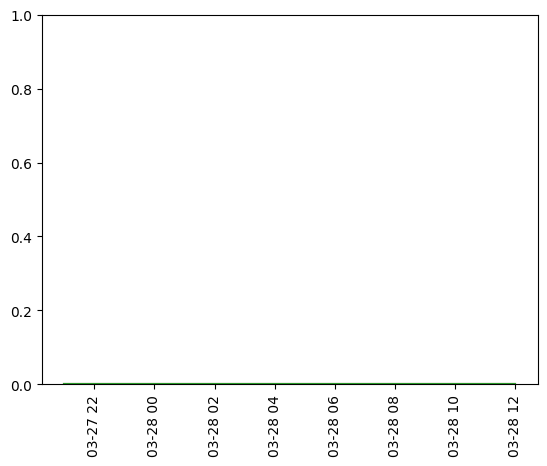

2014-03-28 21:00:00
2014-03-29 12:00:00
2014-03-28 22:00:00 2014-03-29 08:00:00
10


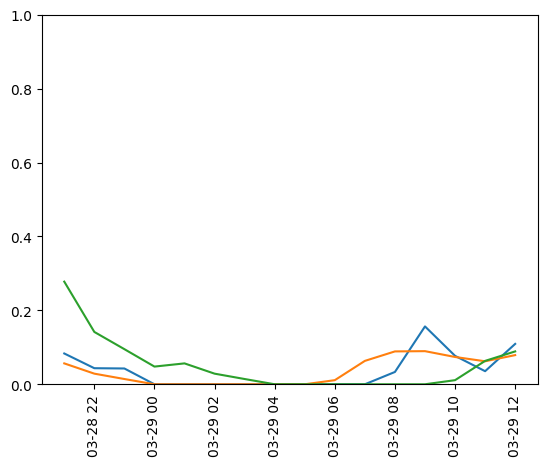

2014-03-29 21:00:00
2014-03-30 12:00:00
nan


/tmp/ipykernel_6623/802887068.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_potential_sleep_interval.fillna(0, inplace=True)


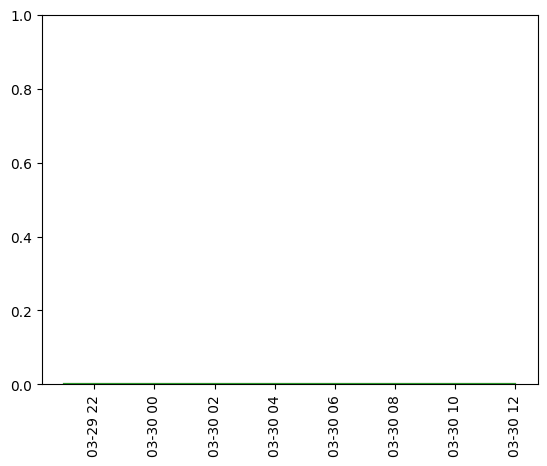

2014-03-30 21:00:00
2014-03-31 12:00:00
2014-03-30 22:00:00 2014-03-31 08:00:00
10


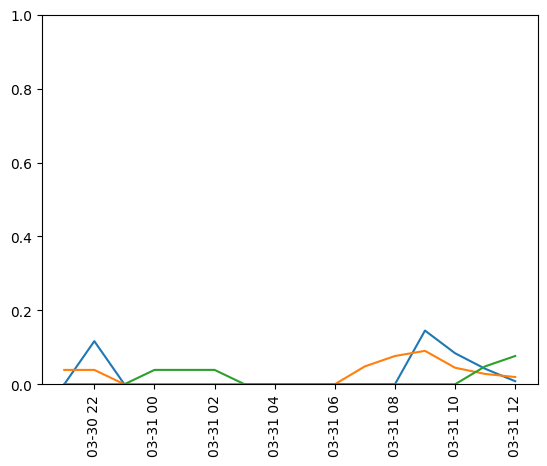

2014-03-31 21:00:00
2014-04-01 12:00:00
nan


/tmp/ipykernel_6623/802887068.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_potential_sleep_interval.fillna(0, inplace=True)


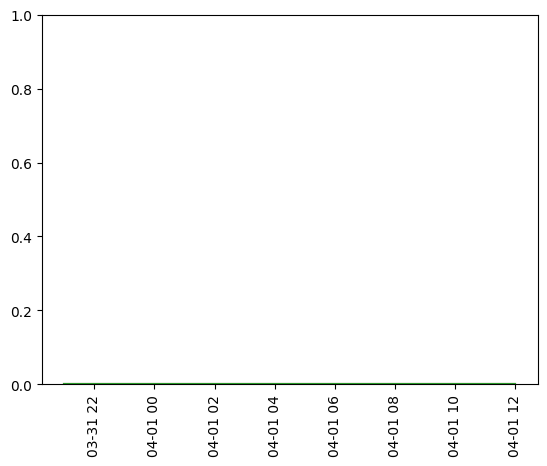

2014-04-01 21:00:00
2014-04-02 12:00:00
2014-04-01 23:00:00 2014-04-02 06:00:00
7


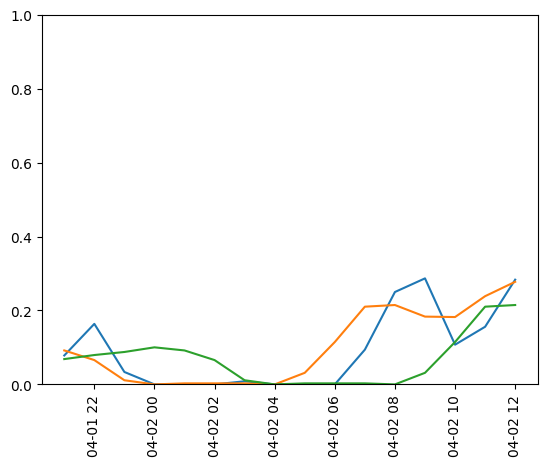

2014-04-02 21:00:00
2014-04-03 12:00:00
nan


/tmp/ipykernel_6623/802887068.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_potential_sleep_interval.fillna(0, inplace=True)


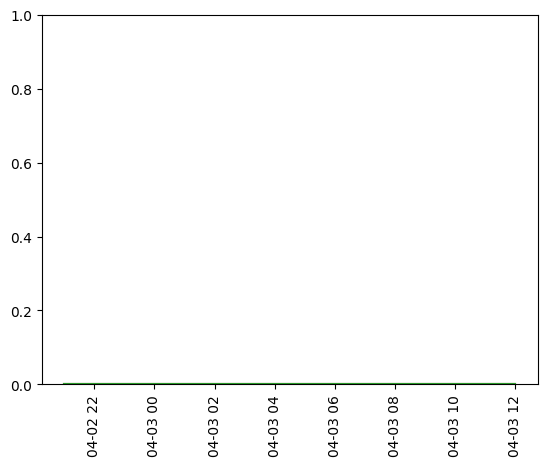

2014-04-03 21:00:00
2014-04-04 12:00:00
2014-04-03 23:00:00 2014-04-04 10:00:00
11


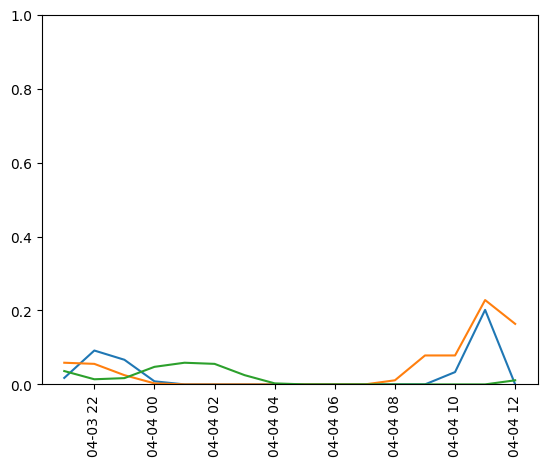

2014-04-04 21:00:00
2014-04-05 12:00:00
2014-04-04 23:00:00 2014-04-05 11:00:00
12


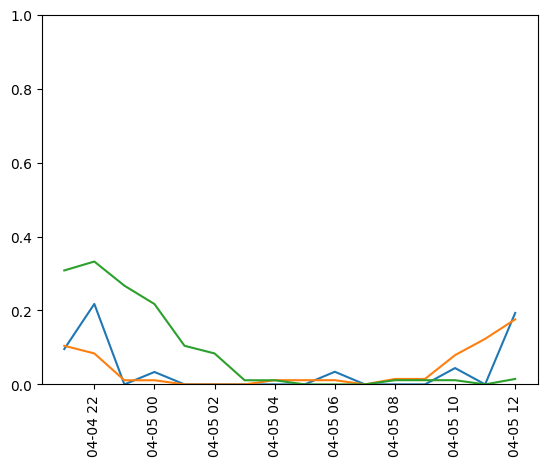

2014-04-05 21:00:00
2014-04-06 12:00:00
nan


/tmp/ipykernel_6623/802887068.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_potential_sleep_interval.fillna(0, inplace=True)


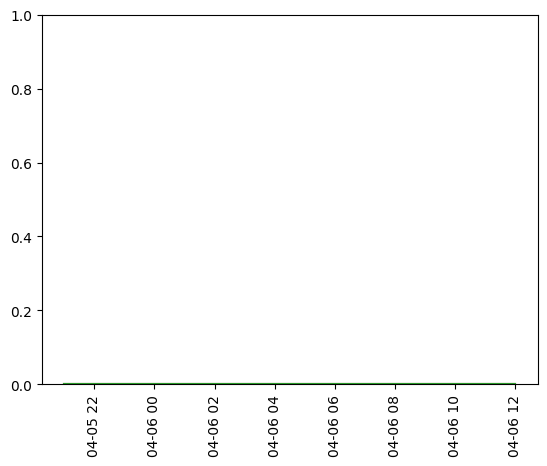

2014-04-06 21:00:00
2014-04-07 12:00:00
2014-04-06 22:00:00 2014-04-07 11:00:00
13


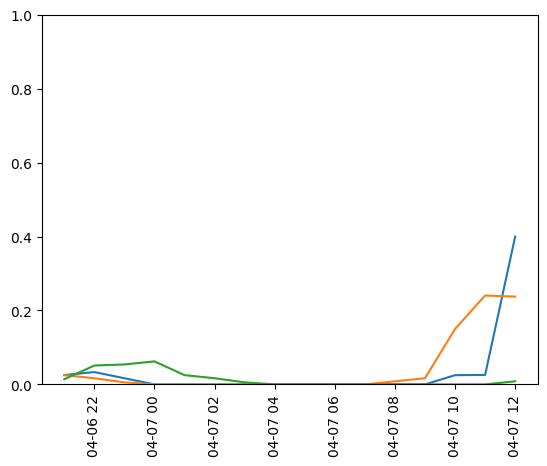

2014-04-07 21:00:00
2014-04-08 12:00:00
nan


/tmp/ipykernel_6623/802887068.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_potential_sleep_interval.fillna(0, inplace=True)


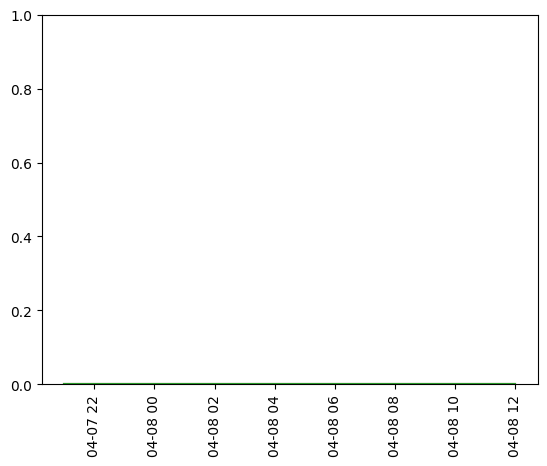

2014-04-08 21:00:00
2014-04-09 12:00:00
2014-04-08 23:00:00 2014-04-09 08:00:00
9


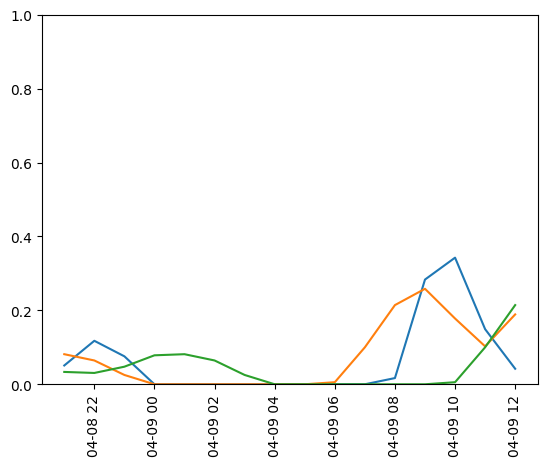

2014-04-09 21:00:00
2014-04-10 12:00:00
nan


/tmp/ipykernel_6623/802887068.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_potential_sleep_interval.fillna(0, inplace=True)


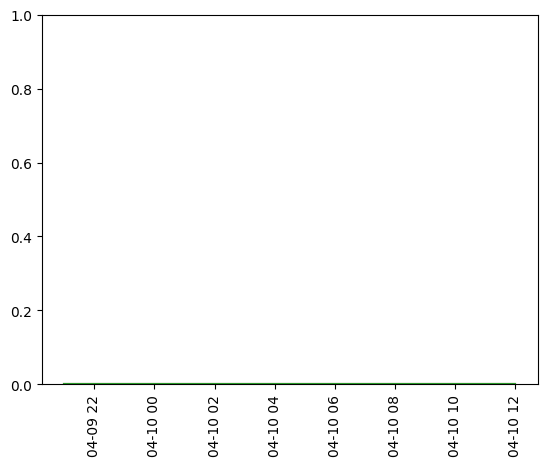

2014-04-10 21:00:00
2014-04-11 12:00:00
2014-04-10 22:00:00 2014-04-11 10:00:00
12


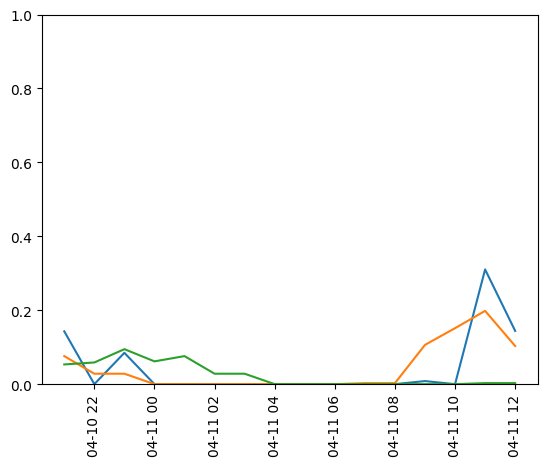

In [4]:
import matplotlib.pyplot as plt
import datetime
import numpy as np
# screen time
df_screen_time = df_cleaned_data[["ID", "date_time", "activity"]].dropna()
df_screen_time["time"] = df_screen_time["date_time"].dt.hour
df_screen_time["day"] = df_screen_time["date_time"].dt.date

i=0
for (pat_id, start_day) in zip(df_screen_time["ID"].unique(), df_screen_time["date_time"].dt.date.unique()):
    #print(pat_id, start_day)
    #print(type(start_day))
    start_day = datetime.datetime.combine(start_day, datetime.time(17, 00))
    end_day = datetime.datetime.combine(start_day + datetime.timedelta(days=1), datetime.time(14, 00))
    # select existing data points
    df_potential_sleep_interval = df_screen_time[
        df_screen_time["ID"] == pat_id &\
        ((df_screen_time["date_time"] >= start_day) & (df_screen_time["date_time"] <= end_day))]
    #print(df_potential_sleep_interval)
    # add missing data points (0s)
    #print(df_potential_sleep_interval["date_time"])
    df_potential_sleep_interval.set_index('date_time', inplace=True)
    date_range = pd.date_range(start=start_day, end=end_day, freq='h')
    # Reindex the DataFrame and add zeros
    df_potential_sleep_interval = df_potential_sleep_interval.reindex(date_range)
    df_potential_sleep_interval.fillna(0, inplace=True)
    df_potential_sleep_interval.reset_index(inplace=True)
    df_potential_sleep_interval = df_potential_sleep_interval.rename(columns={"index": "date_time"})
    df_potential_sleep_interval["activity_rolling_forward"] = df_potential_sleep_interval["activity"].shift(-2).rolling(3).mean()
    df_potential_sleep_interval["activity_rolling_backward"] = df_potential_sleep_interval["activity"].shift(2).rolling(3).mean()

    df_potential_sleep_interval = df_potential_sleep_interval.dropna(subset=["activity_rolling_forward", "activity_rolling_backward"])
    df_potential_sleep_interval.reset_index(inplace=True, drop=True)

    print(df_potential_sleep_interval.iloc[0]["date_time"])
    print(df_potential_sleep_interval.iloc[-1]["date_time"])

    approximated_start, approximated_end = None, None
    for index, (row) in df_potential_sleep_interval.iterrows():
        activity = row["activity"]
        activity_rolling = row["activity_rolling_forward"]
        lower_value = min(activity, activity_rolling)
        if lower_value <= 0.05 and not approximated_start:
            approximated_start = index
        elif lower_value >= 0.05 and approximated_start and not approximated_end:
            approximated_end = index - 1
    if not approximated_start or not approximated_end:
        inactivity_time = np.NaN
    else:
        inactivity_time = approximated_end - approximated_start
        print(df_potential_sleep_interval.loc[approximated_start, "date_time"],
              df_potential_sleep_interval.loc[approximated_end, "date_time"])
    print(inactivity_time)
    # we try to approximate inactivity intervals with the min of both window and actual value
    plt.plot(df_potential_sleep_interval["date_time"], df_potential_sleep_interval["activity"], label="values")
    plt.plot(df_potential_sleep_interval["date_time"], df_potential_sleep_interval["activity_rolling_forward"], label="r_forward")
    plt.plot(df_potential_sleep_interval["date_time"], df_potential_sleep_interval["activity_rolling_backward"], label="r_backward")

    plt.ylim((0, 1))
    plt.xticks(rotation=90)
    plt.show()
    if i==20:
        break
    i+=1
    

# Deep Learning Models

We have to
- create the data in correct format
- normalize the data
- train the model
- evaluate the model

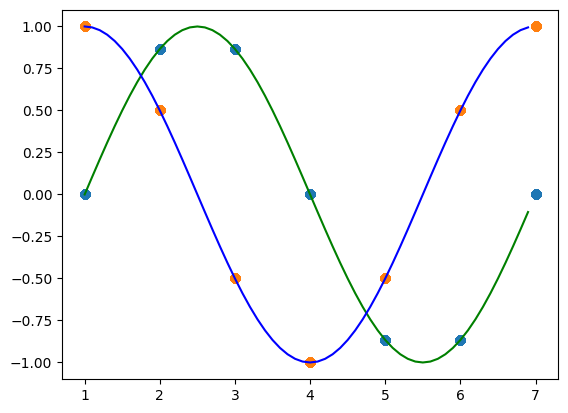

In [39]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt


n_classes = 10
# data
X_features = [
    "mood","circumplex.arousal","circumplex.valence","activity","screen",
    "call","sms", "day_sin", "day_cos", "appCat_total", "appCat.builtin", "appCat.communication",
    "appCat.entertainment", "appCat.finance", "appCat.game", "appCat.office",
    "appCat.social", "appCat.travel", "appCat.unknown", "appCat.utilities", "appCat.weather"

]
Y_features = [
    "mood_of_next_day"
]
df_data = pd.read_csv("./data/imputed_data.csv")
df_data["datetime"] = pd.to_datetime(df_data["datetime"])
df_test = pd.DataFrame()
df_train = pd.DataFrame()
for subject_id in df_data["id"].unique():
    df_subject = df_data[df_data["id"]==subject_id]

    df_subject = df_subject.sort_values(by="datetime")
    split_index = int(0.8 * len(df_subject))
    #subject_test_indices = TimeSeriesSplit(n_splits=2, test_size=len(df_subject)*0.2).split(df_subject)
    df_train = pd.concat([df_train, df_subject.iloc[:split_index]])
    df_test = pd.concat([df_test, df_subject.iloc[split_index:]])

#df_train = pd.read_csv("./data/train_data_imputed.csv", index_col=0)
#df_train["time"] = pd.to_datetime(df_train["time"])
#df_test = pd.read_csv("./data/test_data_imputed.csv", index_col=0)
#df_test["time"] = pd.to_datetime(df_test["time"])


for column in ["screen", "call","sms",*X_features[9:]]:
    df_train[column] = (df_train[column] - df_train[column].mean())/df_train[column].std()
    df_test[column] = (df_test[column] - df_test[column].mean())/df_test[column].std()

min_c, max_c = -2, 2
for column in ["circumplex.arousal", "circumplex.valence"]:
    df_train[column] = (df_train[column] - min_c) / (max_c - min_c)
    df_test[column] = (df_test[column] - min_c) / (max_c - min_c)

for column in ["mood", "mood_of_next_day"]:
    df_train[column] = df_train[column].round(0)
    df_test[column] = df_test[column].round(0)

df_train["day_sin"] = df_train["day_of_week"].apply(lambda x: np.sin((x-1)*(2*np.pi/6)))
df_train["day_cos"] = df_train["day_of_week"].apply(lambda x: np.cos((x-1)*(2*np.pi/6)))
df_test["day_sin"] = df_test["day_of_week"].apply(lambda x: np.sin((x-1)*(2*np.pi/6)))
df_test["day_cos"] = df_test["day_of_week"].apply(lambda x: np.cos((x-1)*(2*np.pi/6)))

x = np.arange(2, 8, 0.1)
x = x-1
y = np.sin((x-1)*(2*np.pi/6))
y_cos = np.cos((x-1)*(2*np.pi/6))
# Plotting Sine Graph
plt.plot(x, y, color='green')
plt.plot(x, y_cos, color="blue")
plt.scatter(np.array(df_train["day_of_week"]), np.array(df_train["day_sin"]))
plt.scatter(np.array(df_train["day_of_week"]), np.array(df_train["day_cos"]))

plt.show()

# remove this later
#df_train["next_mood"] = df_train["mood"].shift(-1)
#df_train = df_train.dropna(subset="mood")

#df_test["next_mood"] = df_train["mood"].shift(-1)
#df_test = df_test.dropna(subset="mood")

X_train = df_train[X_features].astype(np.float64).values
Y_train_regression = np.round(df_train[Y_features].astype(np.float32).values, decimals=0)
Y_train_classification = tf.one_hot(Y_train_regression-1, n_classes)

X_test = df_test[X_features].astype(np.float64).values
Y_test_regression = np.round(df_test[Y_features].astype(np.float64).values, decimals=0)
Y_test_classification = tf.one_hot(Y_test_regression.astype(np.int16)-1, n_classes)

# split the values into sequences of the same length
# use sliding window for this!

# data normalization

In [5]:
# z-score normalization

# Model Setup

In [40]:
# window generator
class WindowGenerator():
  def __init__(self, input_width, label_width, label_column, feature_columns,
               df_train, df_val, df_test, num_classes, datetime_label):
    self.feature_columns = feature_columns
    self.num_classes = num_classes
    self.df_train = df_train
    self.df_val = df_val
    self.df_test = df_test
    # Work out the label column indices.
    self.datetime_label = datetime_label
    self.label_column = label_column
    if not label_column:
      raise ValueError("Label column was not specified")

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width

    self.total_window_size = input_width + label_width

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_column}'])
  
  def split_window(self, df_data) -> tuple[np.ndarray, np.ndarray]:
    """Given a dataframe, splits the dataframe into chunks, where one chunk
    is a number of consecutive days. In case one day is missing in the sequence,
    this sequence is dropped. The result will be X data that is windowed, together
    with Y data that is an array of single prediction values.

    Returns:
        tuple[np.ndarray, np.ndarray]: X_windowed, Y, where X_windowed has shape (num_samples, input_width, amount of features)
        and Y is an array with single values (target values).
    """
    # time column should be day date
    df_data["date"] = df_data[self.datetime_label].dt.date
    df_data = df_data.sort_values("date", ascending=True)

    #used_columns = ["mood","circumplex.arousal","circumplex.valence","activity","screen",
    #"call","sms","appCat_total", "day_sin", "day_cos"]#df_data.select_dtypes(include=['float64', 'int64']).columns
    #sed_columns = used_columns.drop(self.label_column).intersection(pd.Index(self.feature_columns))
    X_windowed = np.zeros(shape=(0, self.input_width, len(self.feature_columns)))
    Y = np.empty(shape=(0,))
    # iterate through subjects
    for subject_id in df_data["id"].unique():
      df_subject = df_data[df_data["id"] == subject_id]
      
      obs_start = df_subject["date"].min()
      obs_end = df_subject["date"].max()
      
      if not isinstance(obs_start, datetime.date):
        continue
      current_window_start = obs_start
      # minus one since we include the first and last point
      current_window_end = current_window_start + datetime.timedelta(days=self.total_window_size-1)
      
      while current_window_end <= obs_end:
        data_sample = df_subject[
          ((df_subject["date"] >= current_window_start) &\
          (df_subject["date"] <= current_window_end))
        ]
        if len(data_sample) != self.total_window_size:
          #print("Had to drop a frame due to missing data")
          pass
        else:
          x = np.expand_dims(data_sample[self.feature_columns].values, axis=0)
          X_windowed = np.concatenate([
            X_windowed, x
            ], axis=0)
          added_outcome = np.array([data_sample.iloc[-1][self.label_column]])
          Y = np.concatenate([Y, added_outcome], axis=0)
          #print("added frame")
        current_window_end = current_window_end + datetime.timedelta(days=1)
        current_window_start = current_window_start + datetime.timedelta(days=1)
    print(f"Original sample: {len(df_data)}, windowed data points: {X_windowed.shape[0]}")
    return X_windowed, tf.one_hot(Y-1, self.num_classes)
    
  @property
  def train(self):
    X, y = self.split_window(self.df_train)
    assert X.shape[0] == y.shape[0]
    return X, y

  @property
  def val(self):
    return self.split_window(self.df_val)

  @property
  def test(self):
    return self.split_window(self.df_test)


w_mood = WindowGenerator(7, 0, 
  label_column=Y_features[0], 
  feature_columns=X_features,
  df_train=df_train,
  df_val=None,
  df_test=df_test,
  num_classes=10,
  datetime_label="datetime"
)
X_train_windowed, Y_train = w_mood.train
print(f"Training data shape: {X_train_windowed.shape}")
print(X_train_windowed[0][0])
print(Y_train[0])

Original sample: 980, windowed data points: 765
Training data shape: (765, 7, 21)
[ 6.          0.55        0.55        0.1340501   2.52503301  1.08778607
 -0.47901595 -0.8660254  -0.5         1.81896206  0.54173338  1.48082884
  0.08555424  0.66569183 -0.16014185  0.06350993  1.74995446  2.27722089
 -0.20724835  3.55248874 -0.20165322]
tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)


In [41]:
def compile_and_fit(model, window, patience=30, bs=10, lr=0.01, max_epochs=30):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                metrics=["accuracy"])
  X_train, Y_train = window.train
  X_test, Y_test = window.test
  history = model.fit(x=X_train, y=Y_train, epochs=max_epochs, batch_size=bs,
                      validation_data=(X_test, Y_test),
                      callbacks=[early_stopping])
  return history

Original sample: 980, windowed data points: 765


/home/m/Desktop/Projects/DMT/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 7, 64)          │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,506 (56.66 KB)

 Trainable params: 14,506 (56.66 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

n_classes = 10
MAX_EPOCHS = 50
lr = 0.005
bs = 1


x = w_mood.train[0]
LSTM_model = Sequential([
    Dense(16, activation="relu", input_shape=(x.shape[1], x.shape[2])),
    Dense(32, activation="tanh", input_shape=(x.shape[1], x.shape[2])),
    LSTM(64, dropout=0.2),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(n_classes, activation="softmax")
])
#LSTM_model.summary()

compile_and_fit(LSTM_model, w_mood, patience=30, bs=bs, lr=lr, max_epochs=MAX_EPOCHS)
x, y = w_mood.train
y_hat = LSTM_model.predict(x)
y_hat_index = np.argmax(y_hat, axis=1)
y_actual = np.argmax(y, axis=1)
print(sum(y_hat_index==y_actual)/y_actual.shape[0])


Original sample: 980, windowed data points: 765


/home/m/Desktop/Projects/DMT/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Original sample: 980, windowed data points: 765
Original sample: 261, windowed data points: 87
Epoch 1/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4781 - loss: 1.2988 - val_accuracy: 0.5747 - val_loss: 1.1467
Epoch 2/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5002 - loss: 1.2034 - val_accuracy: 0.5172 - val_loss: 1.1701
Epoch 3/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4776 - loss: 1.2191 - val_accuracy: 0.5402 - val_loss: 1.1695
Epoch 4/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5145 - loss: 1.1752 - val_accuracy: 0.6092 - val_loss: 1.1655
Epoch 5/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5443 - loss: 1.1538 - val_accuracy: 0.5517 - val_loss: 1.2753
Epoch 6/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5104 - loss: 1.1864 - val_accuracy: 0.5172 - val_loss: 1.1802
Epoch 7/50
765/765 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5550 - loss: 1.1212 - val_accuracy: 0.5632 - val_loss: 1.1718
Epoch 8/5